In [49]:
import pandas as pd
import numpy as np
from numpy import NaN
import matplotlib
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('mode.chained_assignment', None)

df = pd.read_csv("../output/all_services.csv", index_col=0, header=0, thousands=',')
df.sample(5)

,Segments,Services,Type,Service,Hires,Price,Price Type,Rating,Zip Code,Capital City,State,Abbreviation,Implied Revenue
56626,Events,Wedding Officiant,Main,Sharon Fleer Weddings,NaN,100.00,NaN,5.00,23454,Virginia Beach,Virginia,VA,NaN
1,Home Improvement,Brick or Stone Repair,Peripheral,Emi Ferreira Masonry,72.00,NaN,NaN,5.00,2903,Providence,Rhode Island,RI,NaN
25329,Home Improvement,Appliance Repair or Maintenance,Peripheral,KC Home Appliance Repair,192.00,80.00,service,5.00,30303,Atlanta,Georgia,GA,"15,360.00"
35916,Wellness,Personal Training,Main,Fast Pace Personal Training inc.,89.00,85.00,NaN,5.00,95112,San Jose,California,CA,"7,565.00"
65570,Home Improvement,Interior Design,Main,DD Designs,NaN,125.00,hour,5.00,33132,Miami,Florida,FL,NaN


In [50]:
df.shape

(14656, 13)

**General quetions:**
1. Which segments is Thumbtack focusing on? Or is Thumbtack consistent in all segments & services?
2. Does the demand & supply in services change from a region to another?
3. Which segments are doing better or worse?
4. Is Thumbtack offering this many services because they have a low # hires/# sellers rate?
5. Are there any segments or services that showcase more uncaptured potential?
6. What types of sellers are the most successful? Individuals or business? Does it depend on the type of service and/or region?

**1. Which segments is Thumbtack focusing on?**

We can first see a basic count of services for each segment

In [51]:
# See ranking by count
segmentCount = df.groupby("Segments")["Segments"].count()
dfSegmentCount = segmentCount.to_frame(name="Count").reset_index()
dfSegmentCount[
    "Contribution"] = dfSegmentCount["Count"] / dfSegmentCount["Count"].sum()
dfSegmentCount.sort_values(by="Count", ascending=False)

,Segments,Count,Contribution
2,Home Improvement,6283,0.43
1,Events,3488,0.24
5,Wellness,1596,0.11
3,Lessons,1494,0.10
0,Business,1256,0.09
4,Pets,539,0.04


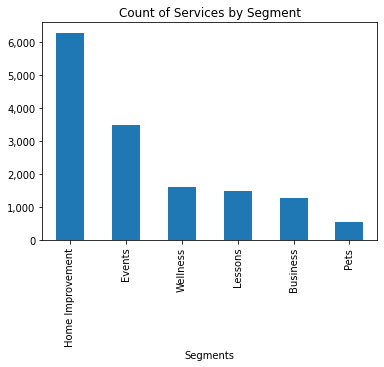

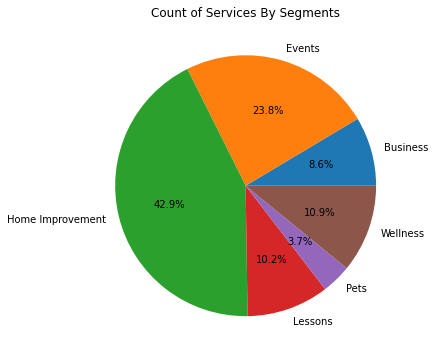

In [52]:
segmentCount.sort_values(ascending=False).plot.bar(title="Count of Services by Segment", )
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
plt.show()

segmentCount.plot.pie(autopct="%.1f%%",
    title="Count of Services By Segments",
    y="Count",
    ylabel="",
    figsize=(6, 6))
plt.show()

In [53]:
# See ranking by count
servicesCount = df.groupby("Services")["Services"].count()
dfServicesCount = servicesCount.to_frame(name="Count").reset_index()
dfServicesCount[
    "Contribution"] = dfServicesCount["Count"] / dfServicesCount["Count"].sum()
dfServicesCount.sort_values(by="Count", ascending=False)[:9]

,Services,Count,Contribution
52,Roof Repair or Maintenance,874,0.06
67,Wedding Officiant,839,0.06
1,Accounting,793,0.05
69,Wedding and Event Makeup,712,0.05
37,Massage Therapy,698,0.05
28,DJ,684,0.05
33,Interior Design,650,0.04
32,House Cleaning,603,0.04
68,Wedding and Event Catering,506,0.03


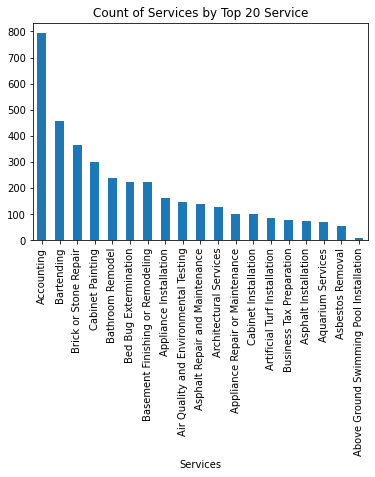

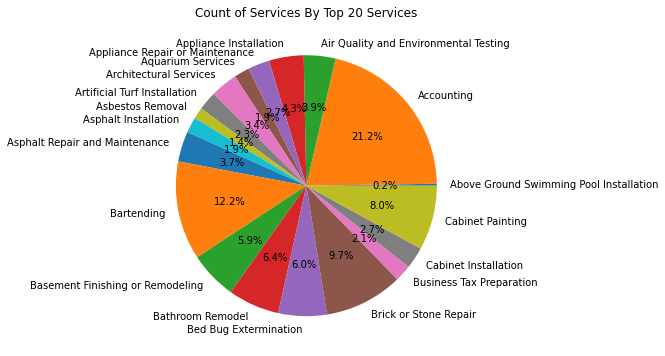

In [54]:
servicesCountChart = servicesCount[:19]
servicesCountChart.sort_values(ascending=False).plot.bar(title="Count of Services by Top 20 Service", )
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
plt.show()

servicesCountChart.plot.pie(autopct="%.1f%%",
    title="Count of Services By Top 20 Services",
    y="Count",
    ylabel="",
    figsize=(6, 6))
plt.show()

Then we can maybe see implied revenue from these segments

In [55]:
# Get sum of implied revenue by segment
dfRevenuBySegment = df.groupby("Segments")["Implied Revenue"].sum().to_frame(
    name="Implied Revenue").reset_index()
dfRevenuBySegment["Contribution"] = dfRevenuBySegment[
    "Implied Revenue"] / dfRevenuBySegment["Implied Revenue"].sum()

# Get sum of implied revenue by services
dfRevenuByServices = df.groupby("Services")["Implied Revenue"].sum().to_frame(
    name="Implied Revenue").reset_index()
dfRevenuByServices["Contribution"] = dfRevenuByServices[
    "Implied Revenue"] / dfRevenuByServices["Implied Revenue"].sum()

# Get sum of implied revenue by states
dfRevenuByRevenue = df.groupby("State")["Implied Revenue"].sum().to_frame(
    name="Implied Revenue").reset_index()
dfRevenuByRevenue["Contribution"] = dfRevenuByRevenue[
    "Implied Revenue"] / dfRevenuByRevenue["Implied Revenue"].sum()

In [60]:
# See implied revenue by segment
dfRevenuBySegment.sort_values(by="Contribution", ascending=False)

,Segments,Implied Revenue,Contribution
1,Events,"21,771,730.00",0.46
2,Home Improvement,"15,242,676.00",0.32
0,Business,"4,122,663.00",0.09
5,Wellness,"3,569,506.00",0.08
3,Lessons,"2,174,409.00",0.05
4,Pets,"307,021.00",0.01


In [57]:
# See top 10 implied revenue by services
dfRevenuByServices.sort_values(by="Contribution", ascending=False)[:9]

,Services,Implied Revenue,Contribution
67,Wedding Officiant,"9,046,401.00",0.19
28,DJ,"5,589,660.00",0.12
42,Photo Booth Rental,"3,617,129.00",0.08
14,Bed Bug Extermination,"3,336,025.00",0.07
21,Carpet Cleaning,"2,453,514.00",0.05
32,House Cleaning,"2,253,694.00",0.05
37,Massage Therapy,"2,156,358.00",0.05
69,Wedding and Event Makeup,"1,802,999.00",0.04
3,Appliance Installation,"1,377,212.00",0.03


In [58]:
# See top 10 implied revenue by zipcode
dfRevenuByRevenue.sort_values(by="Contribution", ascending=False)[:9]

,State,Implied Revenue,Contribution
4,California,"6,658,955.00",0.14
43,Texas,"4,587,978.00",0.10
9,Florida,"3,089,897.00",0.07
30,New Jersey,"2,658,437.00",0.06
32,New York,"1,886,627.00",0.04
25,Missouri,"1,669,121.00",0.04
10,Georgia,"1,660,489.00",0.04
20,Maryland,"1,528,212.00",0.03
13,Illinois,"1,478,376.00",0.03


**2. Does the demand & supply in services change from a region to another?**

Outputs per regional segments & services:
- \# services
- \# hires
- \# hires/#services rate
- List of sellers per region

**3. Which segments are doing better or worse?**

**4. Is Thumbtack offering this many services because they have a low #hires/#sellers rate?**

**5. Are there any segments or services that showcase more uncaptured potential?**

**6. What types of sellers are the most successful? Individuals or business? Does it depend on the type of service and/or region?**